#  Single PDE （Poisson Equation）

##  Poisson Equation with Dirichlet BC

Consider the ode:
$$
\frac{∂^2\Psi(x,y)}{∂x^2} + \frac{∂^2\Psi(x,y)}{∂y^2}= f(x,y),
$$
and $x \in [0,1]$ , $y \in [0,1]$  with Dirichlet boundary conditions (BC):
$$
\Psi(0,y) = f_0(y), \Psi(1,y) = f_1(y), \Psi(x,0) = g_0(x), \Psi(x,1) = g_1(x).
$$
We write the trial solution by:
$$
\hat{\Psi}(x,y, \theta) = A(x,y) + x (1-x)y(1-y) N(x,y, \theta),
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.  

${A(x,y)}$ is chosen so as to satisfy the BC, namely:
$$
A(x,y)=(1-x)f_0(y)+ x f_1(y)+ (1-y) \left\{g_0(x)-[(1-x)g_0(0)+x g_0(1)]\right\} + y \left\{g_1(x)-[(1-x)g_1(0)+x g_1(1)]\right\}
$$

## Poisson Equation with Mixed BC

Mixed boundary conditions (i.e., Dirichlet on part of the boundary and Neumann elsewhere):
$$
\Psi(0,y) = f_0(y), \Psi(1,y) = f_1(y), \Psi(x,0) = g_0(x), \frac{∂\Psi(x,1)}{∂y} = g_1(x).
$$
We write the trial solution by:
$$
\hat{\Psi}(x,y, \theta) = B(x,y) + x (1-x)y[N(x,y, \theta)-N(x,1, \theta)- \frac{∂N(x,1, \theta)}{∂y}],
$$
where $N(x; \theta)$ is a neural network (NN).
The solution is $\hat{\Psi}(x;\theta)$ automatically satisfied the initial conditions.  

${B(x,y)}$ is chosen so as to satisfy the BC, namely:
$$
B(x,y)=(1-x)f_0(y)+ x f_1(y)+ g_0(x)-[(1-x)g_0(0)+x g_0(1)] + y \left\{g_1(x)-[(1-x)g_1(0)+x g_1(1)]\right\}
$$

## Loss funtion

The loss function we would like to minimize to train the NN is:
$$
L(\theta) = \int_0^1 \left[\frac{∂^2\hat{\Psi}(x,y,\theta)}{∂x^2} + \frac{∂^2\hat{\Psi}(x,y,\theta)}{∂y^2} - f(x,y)\right]^2dxdy
$$

# Libraries and Help Functions

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"#否则内核时常挂掉
import torch
import torch.nn as nn
from time import perf_counter
from PIL import Image
import matplotlib.pyplot as plt
from functools import partial
import numpy as np
import requests
import copy
# check if GPU is available and use it; otherwise use CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
partial
def grad(outputs, inputs):
    """
    This is useful for taking derivatives
    """
    return torch.autograd.grad(outputs, inputs, grad_outputs=torch.ones_like(outputs), create_graph=True)[0]

# PDE Examples

## Dirichlet BC case
$$
\nabla^2\Psi(x,y) = e^{-x}(x-2+y^3+6 y),
$$
and $x \in [0,1]$ , $y \in [0,1]$  with Dirichlet boundary conditions (BC):
$$
\Psi(0,y) = y^3, \Psi(1,y) = (1+y^3)e^{-1}, \Psi(x,0) = x e^{-x}, \Psi(x,1) = (x+1)e^{-x}.
$$
The analytic solution is:
$$
\Psi_a(x,y)= e^{-x}(x+y^3)
$$

In [30]:
###################### hyperparameters ######################
neurons=50# neurons in hidden layer
batchsize = 16 # how many points to use per epoch
minibatchsize = 4;
steps1epoch=int(batchsize/minibatchsize);# steps per epoch
max_iter = 100000 # number of epochs
learnrate = 0.01

###################### Poisson's equation ######################

#the input x here has two coordinates X and Y, which are denoted as X = x[:,0][:,None] and Y =  x[:,1][:,None]
#x should contain the X and Y coordinates. Should be of shape: (batch size x 2)

def u_r(x):  
    Ux0 = x[:,1][:,None]**3
    Ux1 = (1 + x[:,1][:,None]**3) / np.exp(1)
    Uy0 = x[:,0][:,None] * torch.exp(-x[:,0][:,None])
    Uy1 = (x[:,0][:,None] + 1) * torch.exp(-x[:,0][:,None])
    A = (1 - x[:,0][:,None]) * Ux0 + x[:,0][:,None] * Ux1 + (1 - x[:,1][:,None])*x[:,0][:,None]*(torch.exp(-x[:,0][:,None]) - np.exp(-1)) + x[:,1][:,None]*(Uy1 -(1- x[:,0][:,None] - 2*x[:,0][:,None]*np.exp(-1)))
    u_r = A + x[:,0][:,None] * (1 - x[:,0][:,None]) * x[:,1][:,None] * (1 - x[:,1][:,None]) * NN(x)
    return u_r

def loss(X):
    X.requires_grad = True
    Uo = u_r(X)
    gradient = grad(Uo,X)
    laplace = grad(gradient,X)
    return torch.mean((laplace[:,0] + laplace[:,1] - torch.exp(-X[:,0][:,None]) * (X[:,0][:,None] - 2 + X[:,1][:,None]**3 +  X[:,1][:,None]))**2)


############### init ###############
NN = nn.Sequential(nn.Linear(2,neurons), 
                   nn.Sigmoid(), 
                   nn.Linear(neurons,1, bias=False)
                  )
adam = torch.optim.Adam(NN.parameters(), lr=learnrate)
step_list = []; loss_list = [];


############### train ###############
for i in range(max_iter):
    X = torch.distributions.Uniform(0, 1).sample((batchsize, 2))
    adam.zero_grad()
    l = loss(X)
    l.backward()
    adam.step()
    # Print the iteration number
    if i % 100 == 99:
        print(i+1)
        print(l)

    loss_list.append(float(l))
    

100
tensor(1.8198, grad_fn=<MeanBackward0>)
200
tensor(4.3548, grad_fn=<MeanBackward0>)
300
tensor(5.5459, grad_fn=<MeanBackward0>)
400
tensor(1.6469, grad_fn=<MeanBackward0>)
500
tensor(5.1103, grad_fn=<MeanBackward0>)
600
tensor(1.8485, grad_fn=<MeanBackward0>)
700
tensor(4.8629, grad_fn=<MeanBackward0>)
800
tensor(7.0824, grad_fn=<MeanBackward0>)
900
tensor(9.4694, grad_fn=<MeanBackward0>)
1000
tensor(5.4547, grad_fn=<MeanBackward0>)
1100
tensor(6.7329, grad_fn=<MeanBackward0>)
1200
tensor(3.5298, grad_fn=<MeanBackward0>)
1300
tensor(6.8358, grad_fn=<MeanBackward0>)
1400
tensor(2.0067, grad_fn=<MeanBackward0>)
1500
tensor(2.0767, grad_fn=<MeanBackward0>)
1600
tensor(8.1289, grad_fn=<MeanBackward0>)
1700
tensor(2.8407, grad_fn=<MeanBackward0>)
1800
tensor(7.2137, grad_fn=<MeanBackward0>)
1900
tensor(5.2612, grad_fn=<MeanBackward0>)
2000
tensor(4.3885, grad_fn=<MeanBackward0>)
2100
tensor(5.2197, grad_fn=<MeanBackward0>)
2200
tensor(4.4249, grad_fn=<MeanBackward0>)
2300
tensor(8.2828,

18200
tensor(1.5671, grad_fn=<MeanBackward0>)
18300
tensor(1.2619, grad_fn=<MeanBackward0>)
18400
tensor(1.7004, grad_fn=<MeanBackward0>)
18500
tensor(2.8757, grad_fn=<MeanBackward0>)
18600
tensor(17.8317, grad_fn=<MeanBackward0>)
18700
tensor(1.8076, grad_fn=<MeanBackward0>)
18800
tensor(8.5499, grad_fn=<MeanBackward0>)
18900
tensor(0.8253, grad_fn=<MeanBackward0>)
19000
tensor(1.2522, grad_fn=<MeanBackward0>)
19100
tensor(1.9347, grad_fn=<MeanBackward0>)
19200
tensor(3.9557, grad_fn=<MeanBackward0>)
19300
tensor(1.6206, grad_fn=<MeanBackward0>)
19400
tensor(1.4300, grad_fn=<MeanBackward0>)
19500
tensor(2.0008, grad_fn=<MeanBackward0>)
19600
tensor(0.5552, grad_fn=<MeanBackward0>)
19700
tensor(42.5779, grad_fn=<MeanBackward0>)
19800
tensor(0.9080, grad_fn=<MeanBackward0>)
19900
tensor(1.4342, grad_fn=<MeanBackward0>)
20000
tensor(1.8656, grad_fn=<MeanBackward0>)
20100
tensor(9.8619, grad_fn=<MeanBackward0>)
20200
tensor(22.9922, grad_fn=<MeanBackward0>)
20300
tensor(1.2006, grad_fn=<M

36000
tensor(2.1631, grad_fn=<MeanBackward0>)
36100
tensor(1.2492, grad_fn=<MeanBackward0>)
36200
tensor(1.3636, grad_fn=<MeanBackward0>)
36300
tensor(0.9754, grad_fn=<MeanBackward0>)
36400
tensor(1.5574, grad_fn=<MeanBackward0>)
36500
tensor(1.7178, grad_fn=<MeanBackward0>)
36600
tensor(1.7764, grad_fn=<MeanBackward0>)
36700
tensor(1.5314, grad_fn=<MeanBackward0>)
36800
tensor(1.8098, grad_fn=<MeanBackward0>)
36900
tensor(1.1132, grad_fn=<MeanBackward0>)
37000
tensor(2.2167, grad_fn=<MeanBackward0>)
37100
tensor(1.4763, grad_fn=<MeanBackward0>)
37200
tensor(0.8770, grad_fn=<MeanBackward0>)
37300
tensor(4.6093, grad_fn=<MeanBackward0>)
37400
tensor(1.6314, grad_fn=<MeanBackward0>)
37500
tensor(1.3545, grad_fn=<MeanBackward0>)
37600
tensor(1.5707, grad_fn=<MeanBackward0>)
37700
tensor(0.9222, grad_fn=<MeanBackward0>)
37800
tensor(4.3239, grad_fn=<MeanBackward0>)
37900
tensor(2.3236, grad_fn=<MeanBackward0>)
38000
tensor(1.9236, grad_fn=<MeanBackward0>)
38100
tensor(1.6874, grad_fn=<Mean

53800
tensor(1.4407, grad_fn=<MeanBackward0>)
53900
tensor(0.8950, grad_fn=<MeanBackward0>)
54000
tensor(1.0502, grad_fn=<MeanBackward0>)
54100
tensor(0.9017, grad_fn=<MeanBackward0>)
54200
tensor(4.9899, grad_fn=<MeanBackward0>)
54300
tensor(0.8837, grad_fn=<MeanBackward0>)
54400
tensor(1.5862, grad_fn=<MeanBackward0>)
54500
tensor(1.7443, grad_fn=<MeanBackward0>)
54600
tensor(1.7725, grad_fn=<MeanBackward0>)
54700
tensor(0.9773, grad_fn=<MeanBackward0>)
54800
tensor(2.4275, grad_fn=<MeanBackward0>)
54900
tensor(2.4984, grad_fn=<MeanBackward0>)
55000
tensor(1.5795, grad_fn=<MeanBackward0>)
55100
tensor(1.7325, grad_fn=<MeanBackward0>)
55200
tensor(3.9768, grad_fn=<MeanBackward0>)
55300
tensor(7.4555, grad_fn=<MeanBackward0>)
55400
tensor(1.1642, grad_fn=<MeanBackward0>)
55500
tensor(1.1308, grad_fn=<MeanBackward0>)
55600
tensor(0.9447, grad_fn=<MeanBackward0>)
55700
tensor(1.8530, grad_fn=<MeanBackward0>)
55800
tensor(0.9189, grad_fn=<MeanBackward0>)
55900
tensor(2.8441, grad_fn=<Mean

71700
tensor(2.8727, grad_fn=<MeanBackward0>)
71800
tensor(1.0536, grad_fn=<MeanBackward0>)
71900
tensor(9.1373, grad_fn=<MeanBackward0>)
72000
tensor(1.3147, grad_fn=<MeanBackward0>)
72100
tensor(1.2493, grad_fn=<MeanBackward0>)
72200
tensor(1.1075, grad_fn=<MeanBackward0>)
72300
tensor(0.6705, grad_fn=<MeanBackward0>)
72400
tensor(1.8532, grad_fn=<MeanBackward0>)
72500
tensor(1.9713, grad_fn=<MeanBackward0>)
72600
tensor(0.6942, grad_fn=<MeanBackward0>)
72700
tensor(0.9748, grad_fn=<MeanBackward0>)
72800
tensor(1.7575, grad_fn=<MeanBackward0>)
72900
tensor(1.0467, grad_fn=<MeanBackward0>)
73000
tensor(0.1644, grad_fn=<MeanBackward0>)
73100
tensor(1.1151, grad_fn=<MeanBackward0>)
73200
tensor(1.4748, grad_fn=<MeanBackward0>)
73300
tensor(1.2228, grad_fn=<MeanBackward0>)
73400
tensor(1.0184, grad_fn=<MeanBackward0>)
73500
tensor(0.8721, grad_fn=<MeanBackward0>)
73600
tensor(1.3833, grad_fn=<MeanBackward0>)
73700
tensor(1.3775, grad_fn=<MeanBackward0>)
73800
tensor(1.7332, grad_fn=<Mean

89500
tensor(1.3873, grad_fn=<MeanBackward0>)
89600
tensor(1.5499, grad_fn=<MeanBackward0>)
89700
tensor(5.7968, grad_fn=<MeanBackward0>)
89800
tensor(1.3738, grad_fn=<MeanBackward0>)
89900
tensor(6.2870, grad_fn=<MeanBackward0>)
90000
tensor(0.8466, grad_fn=<MeanBackward0>)
90100
tensor(0.8375, grad_fn=<MeanBackward0>)
90200
tensor(2.2955, grad_fn=<MeanBackward0>)
90300
tensor(2.7944, grad_fn=<MeanBackward0>)
90400
tensor(2.6209, grad_fn=<MeanBackward0>)
90500
tensor(1.4869, grad_fn=<MeanBackward0>)
90600
tensor(1.2828, grad_fn=<MeanBackward0>)
90700
tensor(1.1645, grad_fn=<MeanBackward0>)
90800
tensor(1.2456, grad_fn=<MeanBackward0>)
90900
tensor(1.0733, grad_fn=<MeanBackward0>)
91000
tensor(0.9870, grad_fn=<MeanBackward0>)
91100
tensor(1.1296, grad_fn=<MeanBackward0>)
91200
tensor(0.6653, grad_fn=<MeanBackward0>)
91300
tensor(1.4447, grad_fn=<MeanBackward0>)
91400
tensor(7.0725, grad_fn=<MeanBackward0>)
91500
tensor(0.8997, grad_fn=<MeanBackward0>)
91600
tensor(1.0064, grad_fn=<Mean

AttributeError: 'builtin_function_or_method' object has no attribute 'ndim'

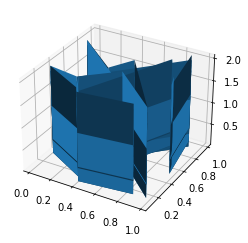

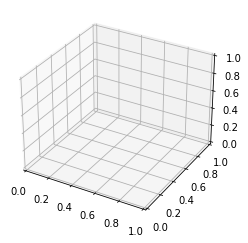

In [19]:
#plot the 3d trial solution
fig = plt.figure()
fig1 = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax1 = fig1.add_subplot(111, projection='3d')

#    ax3.clear()# hold off
#    line3, = ax3.semilogy(step_list, loss_list)
#    ax3.set_xlabel('step');ax3.set_ylabel('loss');
#    ax3.legend(loc='best', markerscale=0.1,  bbox_to_anchor=(1,1))
 
X = torch.distributions.Uniform(0, 1).sample((batchsize, 2))
Ze5sol = u_r(torch.Tensor(X)).detach().numpy()
uA = np.exp(-X[:,0]) * (X[:,0] + X[:,1]**3) # analytic solution

new_shape = int(np.sqrt(X.shape[0]))
ax.plot_surface(X = X[:,0], Y = X[:,1], Z=Ze5sol, label='Adam')

ax1.plot_surface(X = X[:,0], Y = X[:,1], Z = uA.reshape, label='Analytic')
#    ax4.legend(loc='best', markerscale=0.1,  bbox_to_anchor=(1,1));
plt.tight_layout()#否则图部分遮住


## Neumann BC case